In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
from utils.model_operations import *
from utils.image_operations import *
import matplotlib.pyplot as plt


directory_path = os.getcwd()


In [2]:


def loadModelWeights(setName):
    """
    setname: either "train" or "test"
    
    returns dataframe with the weights of all models by layers
    """
    bias = ['0.02', '0.03', '0.04', '0.05']
    df = pd.DataFrame()
    modelId = 0
    for b in bias:
        if setName == "train":
            model_data = ModelDataset(bias=b, data_directory=directory_path+'/data/DigitWdb/train')
        elif setName == "test":
            model_data = ModelDataset(bias=b, data_directory=directory_path+'/data/DigitWdb/test')
        else:
            raise "set name must either be train or test"
            
        temp = []
        for modelNumber in tqdm(range(len(model_data)//1), desc="loading model weights with bias "+b):
            model = model_data[modelNumber]
            layerNumber = 0
            for layer in model.layers:
                if len(layer.get_weights()) != 0:
                    # weights
                    weights = layer.get_weights()[0]
                    # biases
                    biases = layer.get_weights()[1]
                    
                    df = df.append({'modelId':modelId,'weights':np.ravel(weights),'biases':np.ravel(biases),'layer':layerNumber, 'bias':b}, ignore_index=True)
                    layerNumber = layerNumber + 1
            modelId += 1       
    return df
            
trainModelWeights = loadModelWeights("train")
testModelWeights = loadModelWeights("test")


loading model weights with bias 0.05: 100%|██████████| 500/500 [00:34<00:00, 14.62it/s]


computing layers: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


,score
layer,
0.0,0.3595
1.0,0.4480
2.0,0.2605
3.0,0.1895
4.0,0.3135


<AxesSubplot:title={'center':'score of baseline per layer'}, xlabel='layer', ylabel='score'>

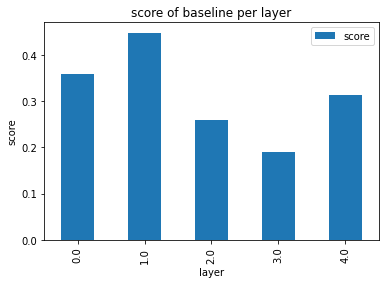

In [21]:
# experiment on the layer level

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

trainModelWeightsCopy = trainModelWeights.copy()
testModelWeightsCopy = testModelWeights.copy()

results = pd.DataFrame(columns=['layer','score'])


for layer in tqdm(range(0,int(trainModelWeightsCopy['layer'].max()+1)), desc="computing layers"):
    tempTrain = trainModelWeightsCopy[trainModelWeightsCopy['layer'] == layer]
    tempTest = testModelWeightsCopy[testModelWeightsCopy['layer'] == layer]

    # extract weights and bias
    X_train = [x[0] for x in tempTrain[['biases']].values] # also possible for weights
    y_train = tempTrain['bias']
    
    X_test = [x[0] for x in tempTest[['biases']].values] # also possible for weights
    y_test = tempTest['bias']

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


    # reduce first with a simple PCA
    pca = PCA(n_components=10)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)


    # use KNN as baseline
    neigh = KNeighborsClassifier(n_neighbors=10)
    neigh.fit(X_train, y_train)

    # predict and evaluate our predictions, bad labeling is 0 or negative, best is 1
    predictions = neigh.predict(X_test)
    
    results = results.append({'layer':layer,'score':accuracy_score(predictions,y_test)}, ignore_index=True)

results = results.set_index('layer')
display(results)
fig = results.plot(kind='bar', xlabel='layer', ylabel='score', title='score of baseline per layer')
fig.get_figure().savefig('baseline.jpg')
display(fig)



computing layers: 100%|██████████| 5/5 [19:38<00:00, 235.69s/it]


,score
layer,
0.0,0.4175
1.0,0.4125
2.0,0.2310
3.0,0.1865
4.0,0.3135


<AxesSubplot:title={'center':'score of baseline per layer'}, xlabel='layer', ylabel='score'>

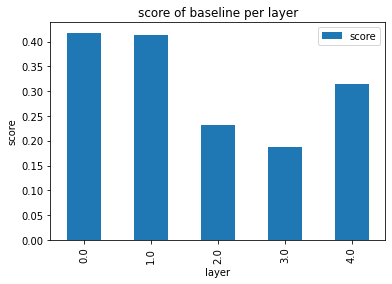

In [85]:
# permutation experiment on the weights level in layer
from sklearn.inspection import permutation_importance

trainModelWeightsCopy = trainModelWeights.copy()
testModelWeightsCopy = testModelWeights.copy()

results = pd.DataFrame(columns=['layer','score'])

permResults = []

for layer in tqdm(range(0,int(trainModelWeightsCopy['layer'].max()+1)), desc="computing layers"):

    tempTrain = trainModelWeightsCopy[trainModelWeightsCopy['layer'] == layer]
    tempTest = testModelWeightsCopy[testModelWeightsCopy['layer'] == layer]

    X_train = [x[0] for x in tempTrain[['biases']].values] 
    y_train = tempTrain['bias']

    X_test = [x[0] for x in tempTest[['biases']].values] 
    y_test = tempTest['bias']

    neigh = KNeighborsClassifier(n_neighbors=10)
    neigh.fit(X_train, y_train)

    #predictions = neigh.predict(X_test)

    results = results.append({'layer':layer,'score':neigh.score(X_test,y_test)}, ignore_index=True)
    
    permResults.append(permutation_importance(neigh, X_train, y_train, n_repeats=3,random_state=42))
    
results = results.set_index('layer')
display(results)
fig = results.plot(kind='bar', xlabel='layer', ylabel='score', title='score of baseline per layer')
fig.get_figure().savefig('baseline2.jpg')
display(fig)

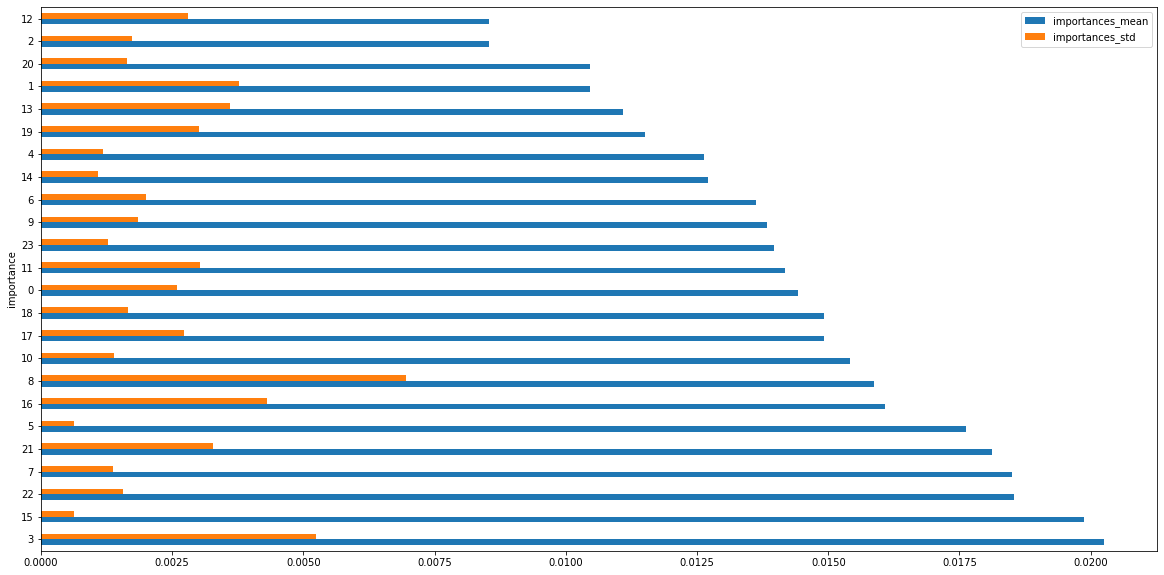

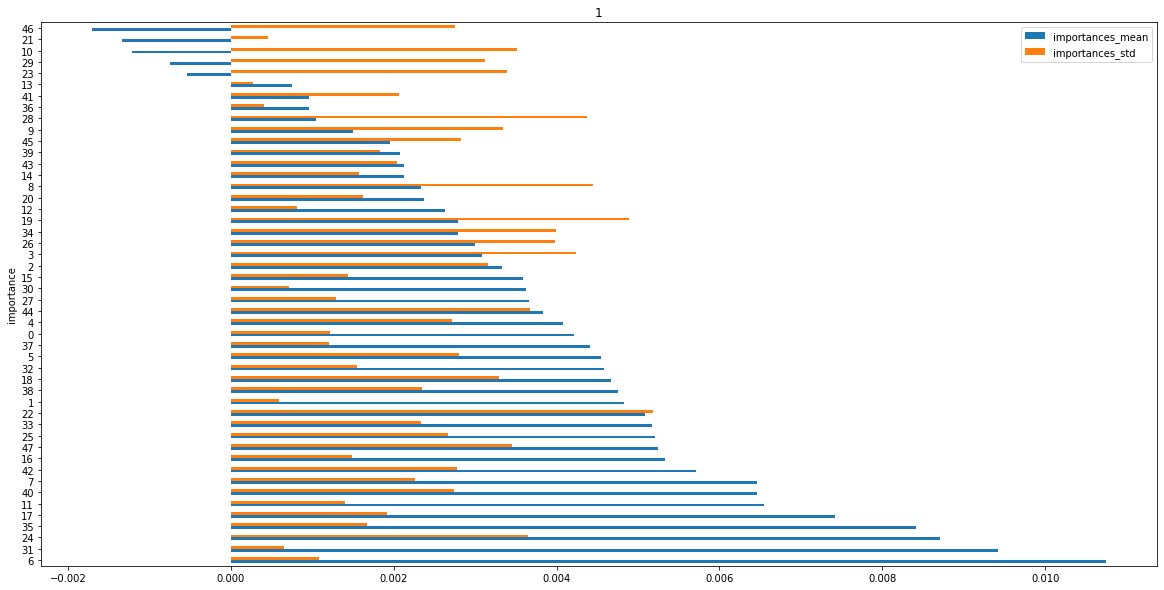

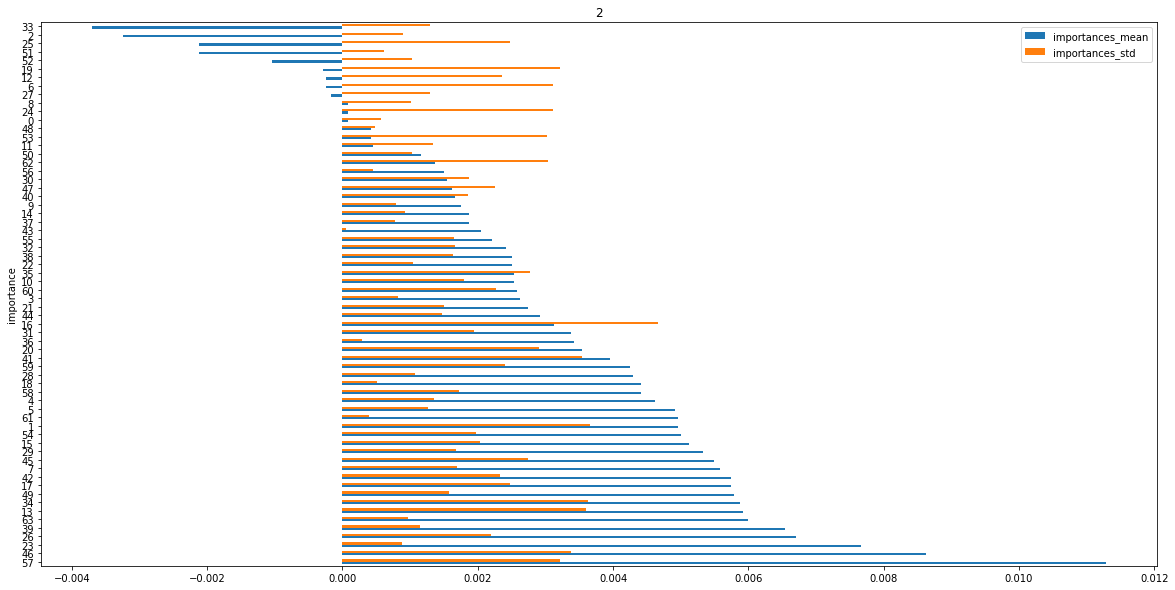

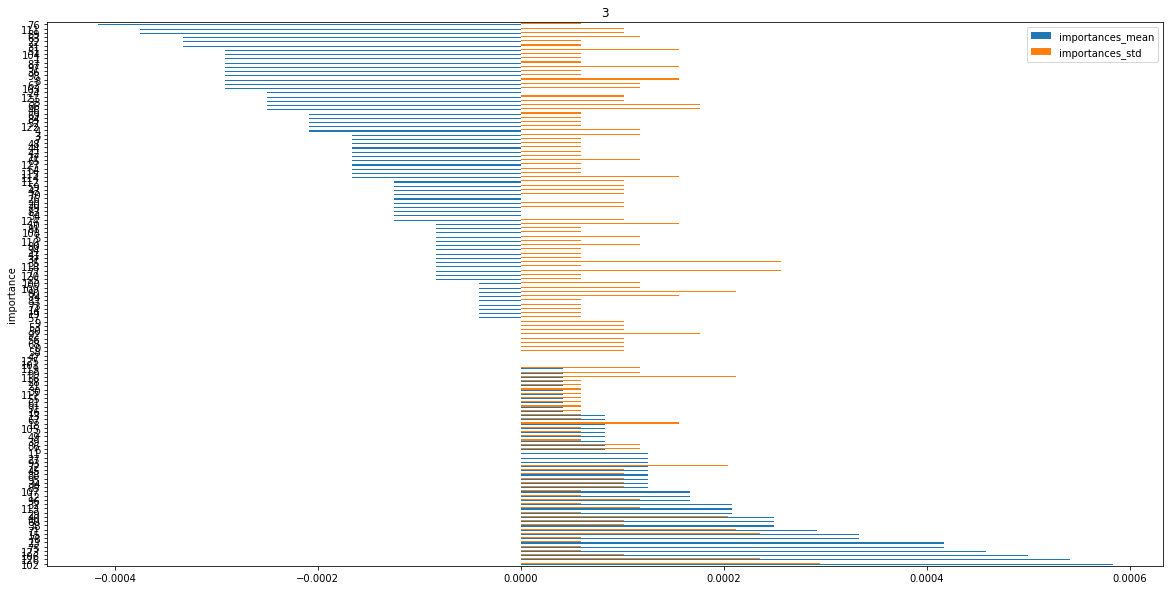

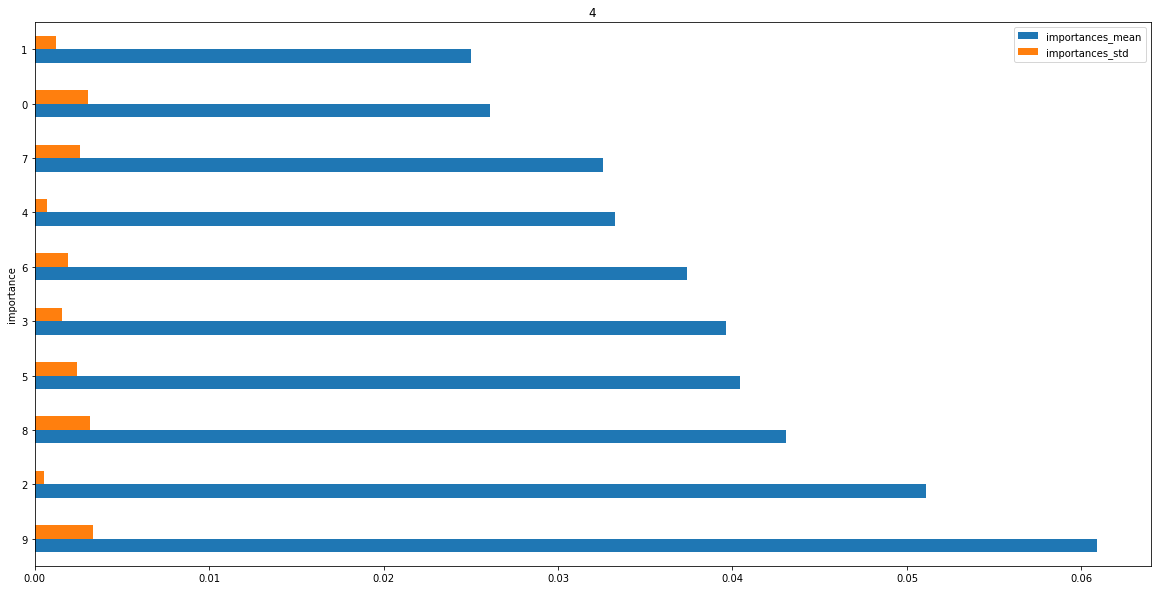

In [88]:
permResultsCopy = permResults.copy()

for layer in range(0,int(trainModelWeightsCopy['layer'].max()+1)):
    data = pd.DataFrame()
    data['importances_mean'] = permResultsCopy[layer]['importances_mean']
    data['importances_std'] = permResultsCopy[layer]['importances_std']
    data = data.sort_values(by=['importances_mean'], ascending=False)
    data.plot(kind='barh', figsize=(20,10), title=layer, xlabel="importance", ylabel="weightId")